In [2]:
import sys
sys.path.insert(0, './Trees')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import subprocess
from scipy.spatial.distance import *
from Utils_dendrograms_OPT import prune_dendro, from_cloud_to_dendro_sublvl
from top_TED_lineare_multiplicity import top_TED_lineare as TED
from copy import deepcopy

from Interleaving_distance import interleaving, interl_approx

In [3]:
from pool_fn import *

In [4]:
import skfda

from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch

from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.datasets import fetch_growth, fetch_octane, fetch_nox, fetch_tecator, fetch_ucr
from scipy.interpolate import interp1d as spline
from scipy.interpolate import CubicSpline as Cspline

In [ ]:
import gtda as go
import gtda.diagrams as diag
import gtda.homology as hl
import ripser as rip

In [5]:
def smooth_data(DATA, b):

    smooth = []
    nw = skfda.preprocessing.smoothing.KernelSmoother(
    kernel_estimator=skfda.misc.hat_matrix.NadarayaWatsonHatMatrix(bandwidth=b))

    for fd in DATA:

        smooth.append(nw.fit_transform(fd))        
        
    return smooth

from numba import jit, int32, prange

@jit(nopython=True, fastmath=True)
def w(x):
    return (35/32)*(1-3*(x**2) + 3*(x**4) - x**6)*(np.abs(x)<=1)

@jit(nopython=True, fastmath=True)
def w_1(x):
    return (35/32)*(-6*x + 12*(x**3) - 6*(x**5))*(np.abs(x)<=1)

@jit(nopython=True, fastmath=True)
def w_2(x):
    return (35/32)*(-6 + 36*(x**2) - 30*(x**4))*(np.abs(x)<=1)


@jit(nopython=True, fastmath=True)
def smooth_numba(f,x,grid,h):
    
    out_1 = np.zeros_like(grid)
    out_2 = np.zeros_like(grid)
    n = len(x)
    
    for i in range(n):
        x_i = x[i]
        y_i = f[i]
        tmp = (grid-x_i)/h
        
        out_1+= w(tmp)*y_i
        out_2+= w(tmp)
    
    return out_1/out_2

Growth


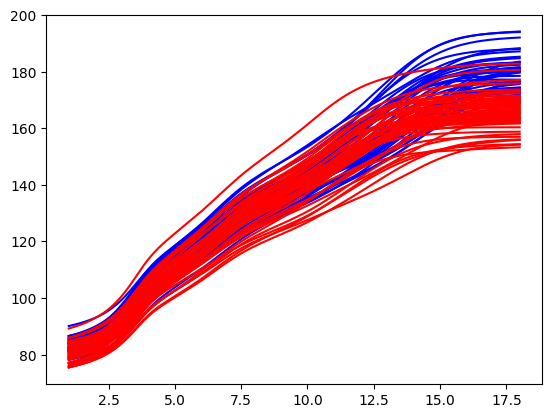

Octane
Nox
Tecator


In [37]:
DATASETS = [fetch_growth,fetch_octane,fetch_nox,fetch_tecator]
NAMES = ['Growth','Octane','Nox','Tecator']
DERIVATIVES = [True,False,False,True]
compute_trees = False
dist_trees = False

LEN =[]

for i,fetch in enumerate(DATASETS):
    
    print(NAMES[i])
    
    
    dataset = fetch()

    data = dataset['data']
    labels = dataset['target']

    FUN = []
    GRID = []
    
    
    if i ==0:

        b = 3

        smooth = []
        grids = []

        for fd in data:

            f = fd.data_matrix[0].reshape(len(fd.data_matrix[0]))
            grid = np.linspace(fd.grid_points[0][0],fd.grid_points[0][-1],200)
            x = fd.grid_points[0]
            f_smooth = smooth_numba(f,x,grid,b)

            smooth.append(f_smooth)
            grids.append(grid)
            
        for j,f in enumerate(smooth):
            plt.plot(grids[j],f,c=colors[labels[j]])
        plt.show()

        for j,f in enumerate(smooth):

            x = grids[j]

            if DERIVATIVES[i]:
                f = np.diff(f)/np.diff(x)
                grid = (x[1:]+x[:-1])/2
            else:
                grid = x

            FUN.append(f)
            GRID.append(grid)
    else:
        for fd in data:

            f = fd.data_matrix[0].reshape(len(fd.data_matrix[0]))
            x = fd.grid_points[0]

            if DERIVATIVES[i]:
                f = np.diff(f)/np.diff(x)
                grid = (x[1:]+x[:-1])/2
            else:
                grid = x

            FUN.append(f)
            GRID.append(grid)


    Norm=np.zeros((len(FUN),len(FUN)))
    
    for z in range(len(FUN)):
        for j in range(len(FUN)):
            if j<z:
                Norm[z,j] = np.max(np.abs(FUN[z]-FUN[j]))

    Norm=Norm+Norm.T    

    if i==0:
        np.save('./Dataset_Matrices/Norm_smooth_'+NAMES[i],Norm)
    else:
        np.save('./Dataset_Matrices/Norm_'+NAMES[i],Norm)

    if compute_trees:
        TREES = []
        

        for j,f in enumerate(FUN):

            print(j,end='\r')

            D=np.arange(len(f))

            T = from_cloud_to_dendro_sublvl(D,f,1.01, None,\
                                            prec = 0.0000001, prune_param = None, ITris=[])

            T.make_mult(f=False)

            TREES.append(T)
            
        LEN.append(np.sort([len(t.leaves) for t in TREES])[::-1])

    if dist_trees:
        
        D=np.zeros((len(TREES),len(TREES)))
        for z in range(len(TREES)):

            print('Siamo alla riga: ',z)

            for j in range(len(TREES)):
                if j<z:
                    D[z,j] = interleaving(TREES[z], TREES[j], binary=True,approx='up', 
                                          MP=True, check=False,
                                          verbose = False)

        D_I_up=D+D.T

        if i==0:
            np.save('./Dataset_Matrices/D_I_up_smooth_'+NAMES[i],D_I_up)
        else:
            np.save('./Dataset_Matrices/D_I_up_'+NAMES[i],D_I_up)
        
        D=np.zeros((len(TREES),len(TREES)))
        for z in range(len(TREES)):

            print('Siamo alla riga: ',z)

            for j in range(len(TREES)):
                if j<z:
                    D[z,j] = interleaving(TREES[z], TREES[j], binary=True,approx='low', 
                                          MP=True, check=False,
                                          verbose = False)

        D_I_low=D+D.T
        
        if i==0:
            np.save('./Dataset_Matrices/D_I_low_smooth_'+NAMES[i],D_I_low)
        else:    
            np.save('./Dataset_Matrices/D_I_low_'+NAMES[i],D_I_low)

    DGMS = []
    
    MAX = -1
        
    for j,f in enumerate(FUN):

        print(j,end='\r')

        dgm = rip.lower_star_img(np.array([f]))
        dgm = dgm[dgm[:,1]<999999999999]

        DGMS.append(dgm)
        MAX = max(MAX, DGMS[-1].shape[0])
    
    AUX=np.zeros((len(data),MAX,3))
    
    for z,dgm in enumerate(DGMS):
        AUX[z,:dgm.shape[0],:]=np.c_[dgm, np.zeros((dgm.shape[0],))]


    dist = diag.PairwiseDistance(metric='bottleneck', n_jobs=2).fit(AUX)

    PD = dist.transform(AUX)
        
    np.save('./Dataset_Matrices/PD_'+NAMES[i],PD)
   

In [6]:
for i,fetch in enumerate(DATASETS):    
    dataset = fetch()
    data = dataset['data']
    
    if NAMES[i] == 'Tecator':
        y = dataset['target'][:,0]
        labels = y<20
    else:
        labels = dataset['target']
        
    _,counts = np.unique(labels, return_counts=True)
        
    print(NAMES[i],len(data),LEN[i][:10],LEN[i][-10:], np.median(LEN[i]),counts)   

Growth 93 [9 8 8 8 7 7 7 7 7 7] [4 4 4 4 4 4 4 4 4 4] 5.0 [39 54]
Octane 39 [5 5 5 5 5 5 5 5 5 5] [4 4 4 4 4 4 4 4 4 4] 4.0 [33  6]
Nox 115 [8 8 8 8 8 8 7 7 7 7] [4 4 4 4 4 4 3 3 3 2] 5.0 [76 39]
Tecator 215 [10  9  9  8  7  7  7  7  7  7] [3 3 3 3 3 3 3 3 2 2] 5.0 [ 77 138]
